In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author: Sidi Wu and Cédric Beaulac

Functional autoencoder implementation
"""

# Import modules
import sys
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev
import skfda


In [2]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

0

In [3]:

# os.chdir('C:/FAE')
os.chdir('C:/Users/Utilisateur/Documents/Master_SSD/STAGE_RECHERCHE/FDA_python')
if not os.getcwd() in sys.path:
    sys.path.append(os.getcwd())
import DataGenerator
from DataGenerator import *
import DataGenerator_NN
from DataGenerator_NN import *
import Functions
from Functions import *


In [4]:
help(DataGenerator)

Help on function DataGenerator in module DataGenerator:

DataGenerator(nc=250, tpts=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), classes=4, noise=2)
    # nc: number of data points per *class*, classes: number of classes/cluster, noise:std of the normal noise



In [5]:
##Importation des données sous forme FDA

ElNino_OISST_region_1and2=skfda.datasets.fetch_cran("ElNino_OISST_region_1and2","rainbow")
ElNino_OISST_region_3=skfda.datasets.fetch_cran("ElNino_OISST_region_3","rainbow")
ElNino_OISST_region_4=skfda.datasets.fetch_cran("ElNino_OISST_region_4","rainbow")
ElNino_OISST_region_3and4=skfda.datasets.fetch_cran("ElNino_OISST_region_3and4","rainbow")


c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fds". The underlying R object is returned instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" w

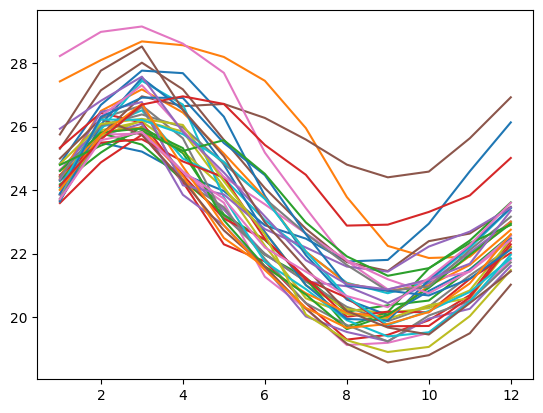

In [6]:
ElNino_OISST_region_1and2_y=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['y'].to_numpy()
ElNino_OISST_region_1and2_x=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['x']
plt.plot(ElNino_OISST_region_1and2_x,ElNino_OISST_region_1and2_y)
plt.show(
)

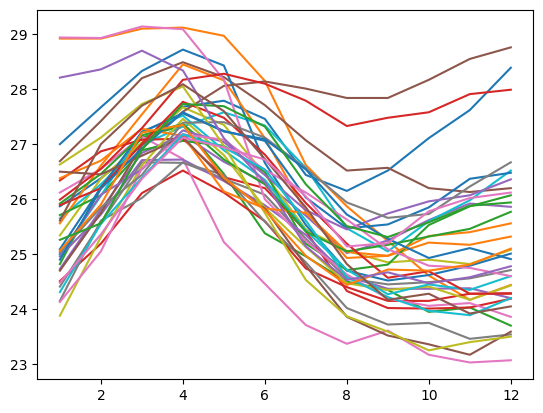

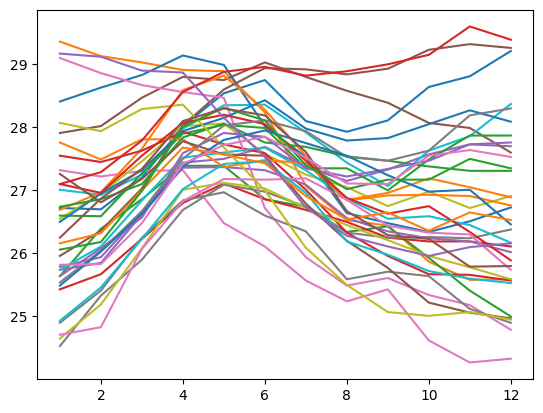

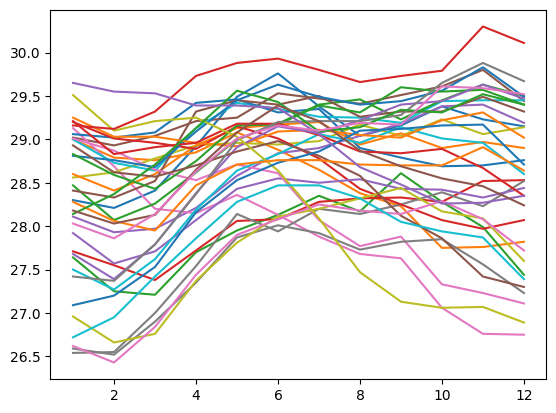

In [7]:
ElNino_OISST_region_3_y=ElNino_OISST_region_3['ElNino_OISST_region_3']['y'].to_numpy()
ElNino_OISST_region_3_x=ElNino_OISST_region_3['ElNino_OISST_region_3']['x']
plt.plot(ElNino_OISST_region_3_x,ElNino_OISST_region_3_y)
plt.show(

)
ElNino_OISST_region_3and4_y=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['y'].to_numpy()
ElNino_OISST_region_3and4_x=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['x']
plt.plot(ElNino_OISST_region_3and4_x,ElNino_OISST_region_3and4_y)
plt.show(
)


ElNino_OISST_region_4_y=ElNino_OISST_region_4['ElNino_OISST_region_4']['y'].to_numpy()
ElNino_OISST_region_4_x=ElNino_OISST_region_4['ElNino_OISST_region_4']['x']
plt.plot(ElNino_OISST_region_4_x,ElNino_OISST_region_4_y)
plt.show(
)

In [9]:
grid_points=ElNino_OISST_region_1and2_x
[ElNino_OISST_region_1and2_y.shape,

print("grid_points=",grid_points)]

grid_points= [ 1  2  3  4  5  6  7  8  9 10 11 12]


[(12, 37), None]

In [10]:
x0=torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
x1=torch.tensor(ElNino_OISST_region_3_y).float().cuda()
x2=torch.tensor(ElNino_OISST_region_4_y).float().cuda()
x3=torch.tensor(ElNino_OISST_region_3and4_y).float().cuda()
x0=torch.t(x0)
x1=torch.t(x1)
x2=torch.t(x2)
x3=torch.t(x3)

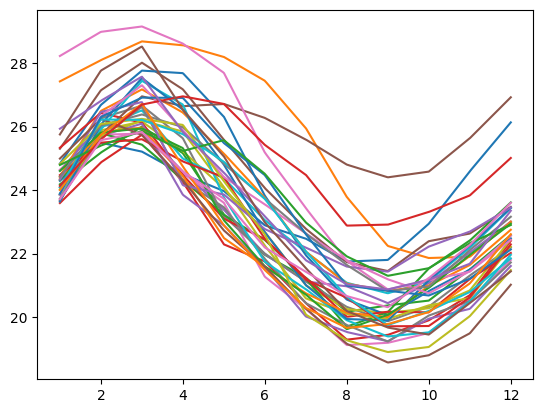

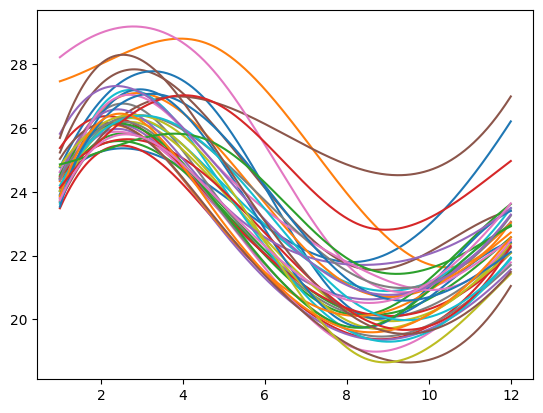

In [11]:
fd=skfda.FDataGrid(torch.t(torch.tensor(ElNino_OISST_region_1and2_y)),grid_points=ElNino_OISST_region_1and2_x)
basis=skfda.representation.basis.BSplineBasis(knots=np.linspace(1,12,4),order=4)
fd_basis=fd.to_basis(basis=basis)
fd.plot()
fd_basis.plot()
plt.show()

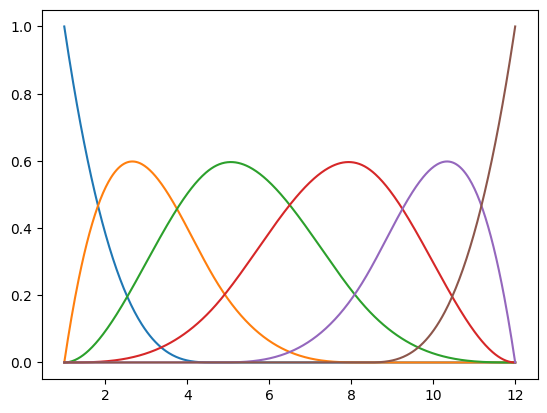

In [12]:
basis.plot()

On choisi le lissage par Bspline dont la base est déterminée par les noeuds linspace(1,12,4) et un order 4 d'interpolation.
Le nombre de basis est donc égale à :
(4+4-2)=6 



In [13]:
class CNN_FAE(nn.Module):
    def __init__(self,):
        super(CNN_FAE,self).__init__()

            
        self.CNN_Conv=nn.Sequential(    
            nn.Conv1d(1,37,kernel_size=5,stride=[1],padding=[1],bias =True,dilation=1),
            
        )    
        self.Linear=nn.Sequential(    
            nn.Linear(10,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.15,inplace=True),
            nn.Linear(512,256),

            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.15,inplace=True),
            nn.Linear(128,64),
        )
        self.CNN_ConvTranspose=nn.Sequential(    
            nn.ConvTranspose1d(37,1,stride=1,padding=29,kernel_size=7),
            

        )



    def forward(self,functions):

        conv_out=self.CNN_Conv(functions)
        Linear_out=self.Linear(conv_out)
        deconv_out=self.CNN_ConvTranspose(Linear_out)
        
        
        return deconv_out.float()

In [14]:
x =torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
w = x.size(1)-1
W = torch.tensor([1/(2*w)]+[1/w]*(w-1)+[1/(2*w)])
W
x.size()
basis


BSplineBasis(domain_range=((1.0, 12.0),), n_basis=6, order=4, knots=(1.0, 4.666666666666666, 8.333333333333332, 12.0))

In [15]:

FD_grid_region_1and_2=skfda.representation.FDataGrid(x0.detach().cpu(),grid_points=ElNino_OISST_region_1and2_x)
FD_grid_region_3=skfda.representation.FDataGrid(x1.detach().cpu(),grid_points=ElNino_OISST_region_3_x)
FD_grid_region_4=skfda.representation.FDataGrid(x2.detach().cpu(),grid_points=ElNino_OISST_region_4_x)
FD_grid_region_3and_4=skfda.representation.FDataGrid(x3.detach().cpu(),grid_points=ElNino_OISST_region_3and4_x)

##Une fois les coefficients récupérés, on en fait une fonction de x puis 
##x vaudra une discrétisation du temps.
##On va zoomer la courbe pour faire de la convolution.


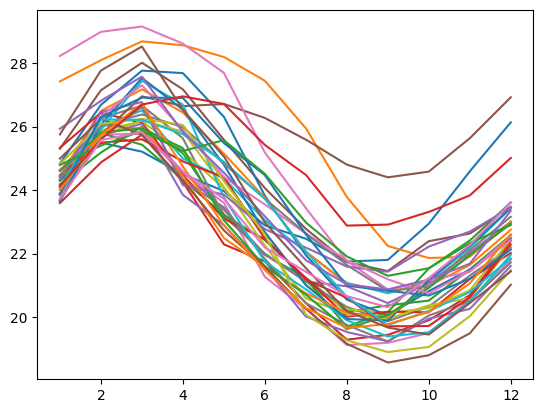

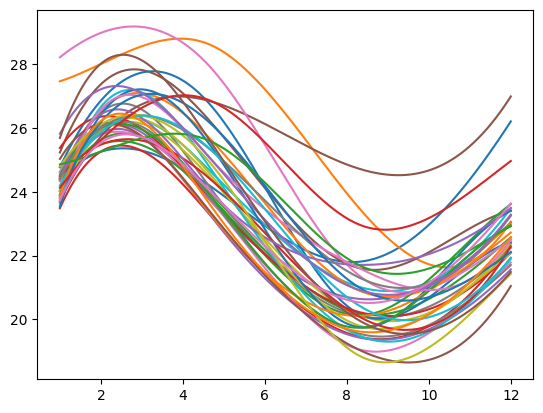

In [16]:

skfda.FDataGrid(x0.detach().cpu(),grid_points=ElNino_OISST_region_1and2_x).plot()
plt.show()
FD_grid_region_1and_2.to_basis(basis).plot()
plt.show()

In [17]:

CNN=CNN_FAE()
CNN=CNN.cuda()
Conv_out=CNN.CNN_Conv(x0[1,:].unsqueeze(0))
[x0.shape,Conv_out.shape,]



[torch.Size([37, 12]), torch.Size([37, 10])]

['conv_out shape=', torch.Size([37, 10])]


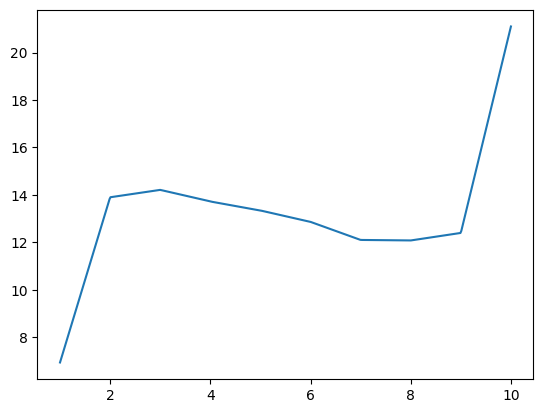

Smoothed convlayer


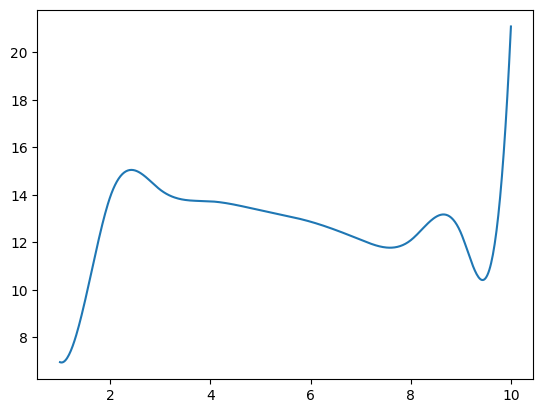

['conv_out shape=', torch.Size([37, 10])]


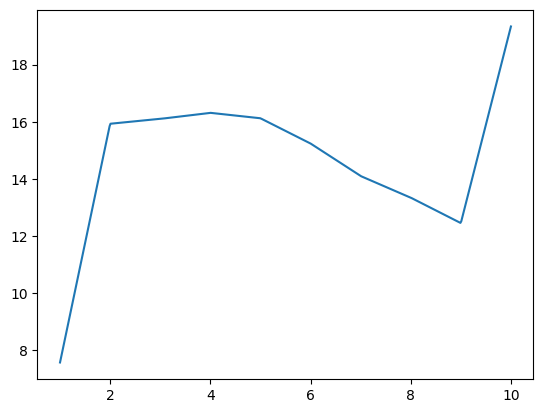

Smoothed convlayer


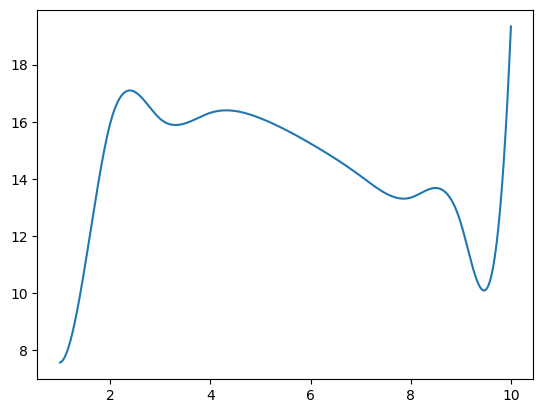

['conv_out shape=', torch.Size([37, 10])]


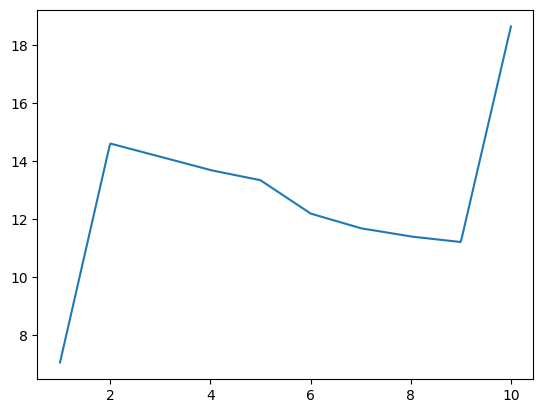

Smoothed convlayer


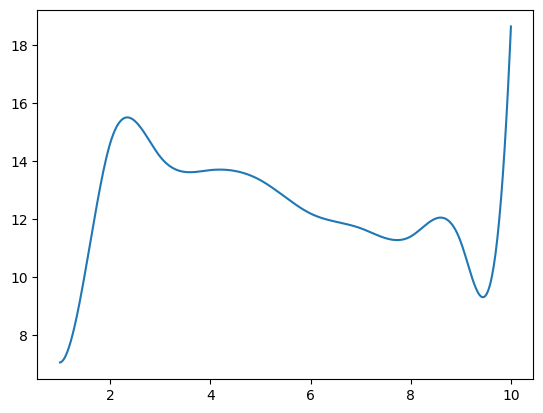

['conv_out shape=', torch.Size([37, 10])]


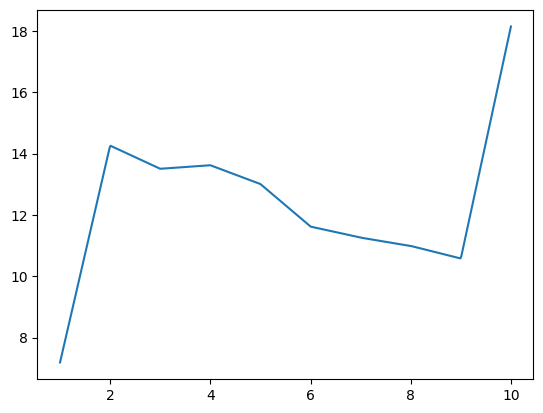

Smoothed convlayer


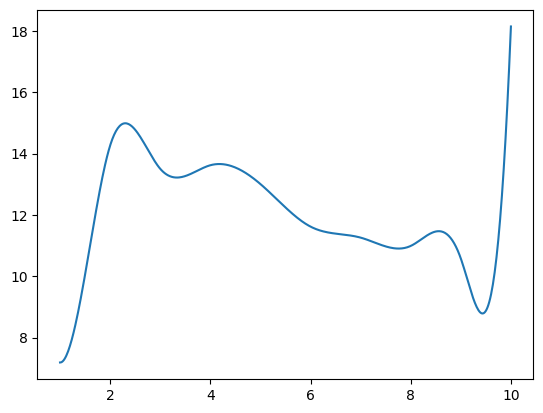

In [20]:

output_CNN_FAE=CNN.CNN_Conv(x2[1,:].unsqueeze(0))
n_conv_out=Conv_out.shape[1]
basis_conv_out=skfda.representation.basis.BSplineBasis(knots=linspace(1,n_conv_out,n_conv_out))
for i in range(4):
    CNN.FD=skfda.FDataGrid(CNN.CNN_Conv(x0[i,:].unsqueeze(0))[1,:].detach().cpu(),grid_points=linspace(1,n_conv_out,n_conv_out))
    print(["conv_out shape=",Conv_out.shape])
    CNN.FD.plot()
    plt.show()
    print("Smoothed convlayer")
    CNN.FD.to_basis(basis_conv_out).plot()
    plt.show()

torch.Size([37, 64])


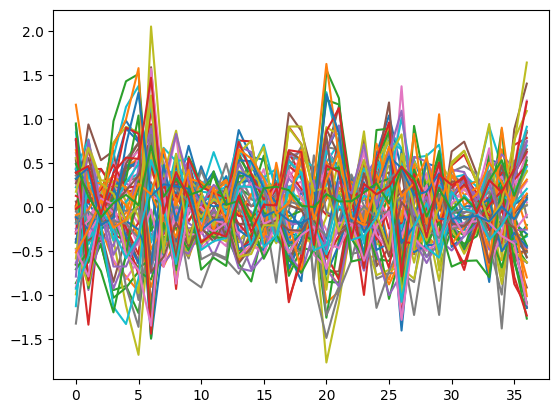

In [21]:

Lin_out=CNN.Linear(Conv_out)
print(Lin_out.shape)
plt.plot(Lin_out.detach().cpu())
plt.show()

Output du FAE de convolution:


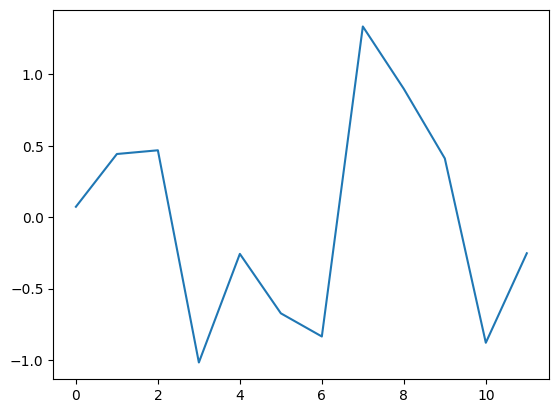

torch.Size([1, 12])

In [22]:
Deconv_out=CNN.CNN_ConvTranspose(Lin_out)
plt.plot(torch.t(Deconv_out).detach().cpu())
print('Output du FAE de convolution:')
plt.show()
Deconv_out.shape

In [23]:
n_output_CNN_FAE=CNN(x2[1,:].unsqueeze(0)).shape[1]

[CNN(x0[1,:].unsqueeze(0)).shape,
x0.shape]

[torch.Size([1, 12]), torch.Size([37, 12])]

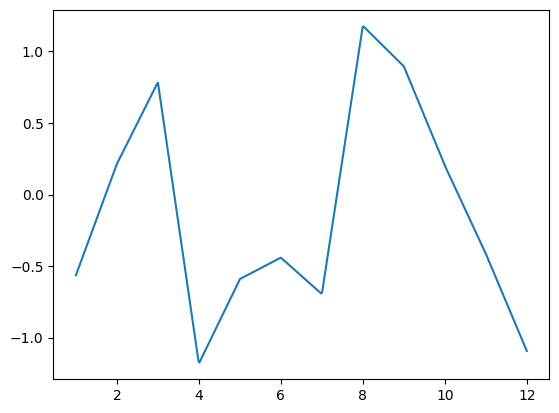

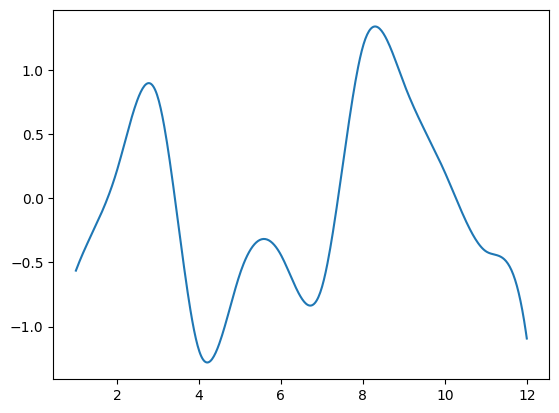

In [24]:

basis_output_CNN_FAE=skfda.representation.basis.BSplineBasis(knots=linspace(1,n_output_CNN_FAE,n_output_CNN_FAE))
FDOutput=skfda.FDataGrid(CNN(x3[0,:].unsqueeze(0))[:,:].detach().cpu(),grid_points=linspace(1,n_output_CNN_FAE,n_output_CNN_FAE))
FDOutput.plot()
plt.show()
FDOutput.to_basis(basis=basis_output_CNN_FAE).plot()
plt.show()

In [25]:
lr=0.001
betas=[0.5,0.999]
batch_size=3

loss_function=nn.MSELoss()
optimizer=optim.Adam(CNN.parameters(),lr=lr,betas=betas)
indice=np.arange(37)


#print("Loader entier=",train_loader.dataset.shape)
#for i,b in enumerate(train_loader):
#    print ("Itération du",i,"ème batch=",b.shape)

In [26]:

from tqdm import tqdm
def train(n_epochs,x0):
    train_loss=torch.tensor(0).cuda()
    train_loader=torch.utils.data.DataLoader(x0)

    for i,functions_train in enumerate(train_loader):
        functions_train=functions_train.float().cuda()
        optimizer.zero_grad()
        output=CNN(functions_train).float().cuda()
        loss=loss_function(output.float(),functions_train.float().cuda())
        
        loss.backward()
        optimizer.step()
        train_loss+=loss.long()
    return train_loss,loss 

        


        


In [33]:
region_de_test=x3
train(1,region_de_test)

(tensor(36, device='cuda:0'),
 tensor(1.1499, device='cuda:0', grad_fn=<MseLossBackward0>))

Ce que l'on recréer


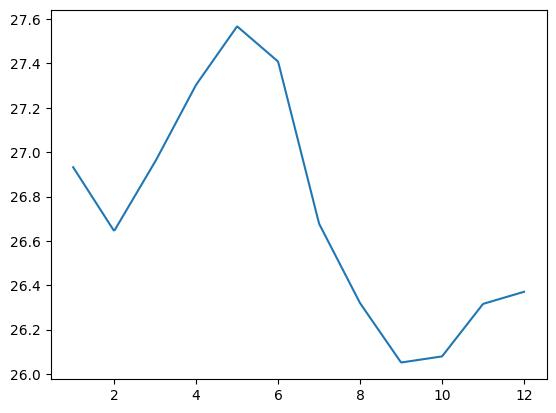

Ce que l'on est censé recréer


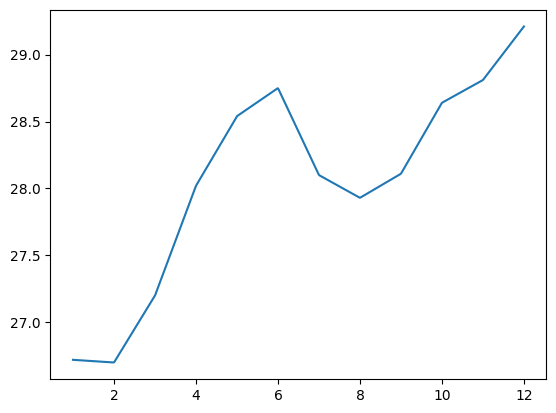

Smooth par B-Spline de ce que l'on a recréé


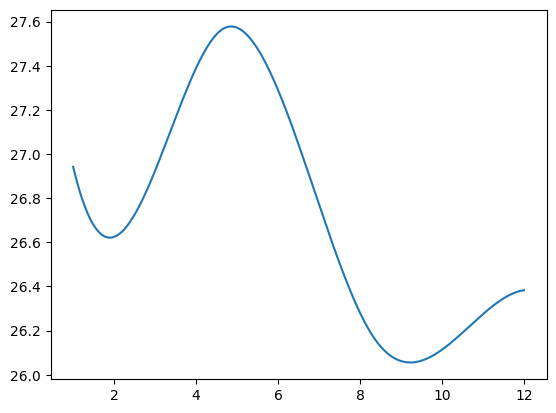

Ce que l'on est censé recréer mais smooth


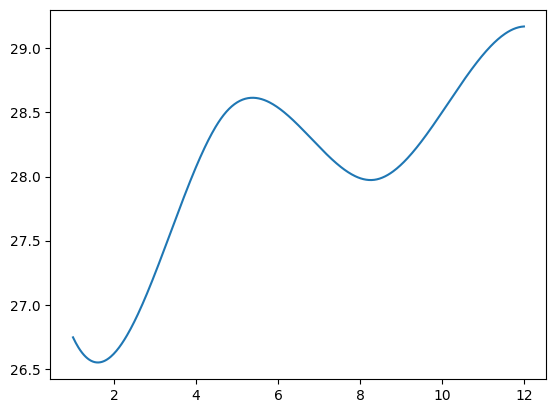

Ce que l'on recréer


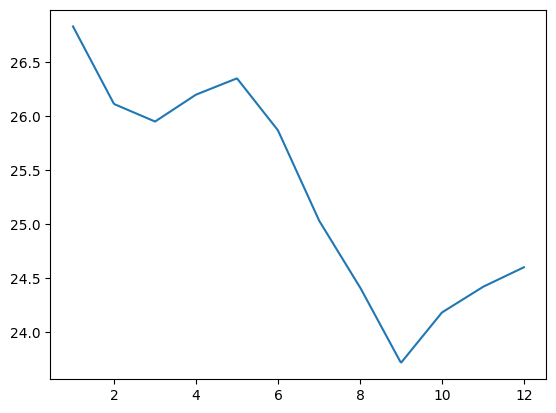

Ce que l'on est censé recréer


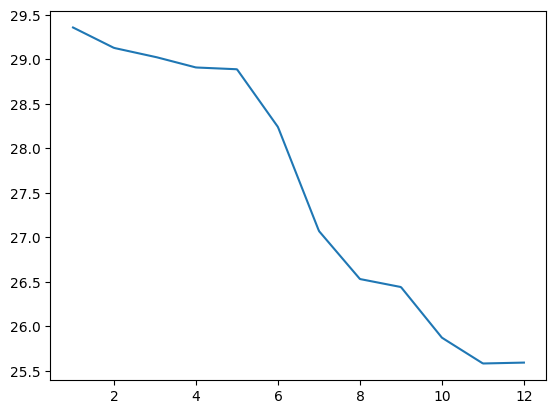

Smooth par B-Spline de ce que l'on a recréé


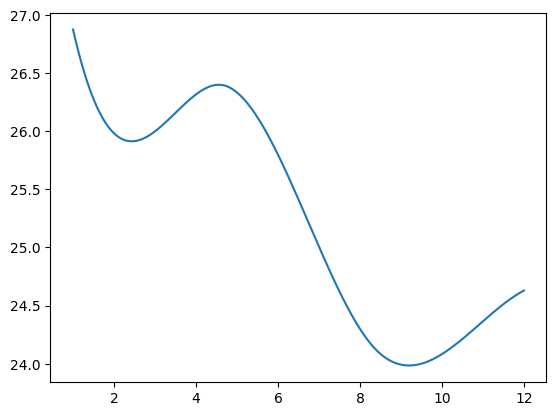

Ce que l'on est censé recréer mais smooth


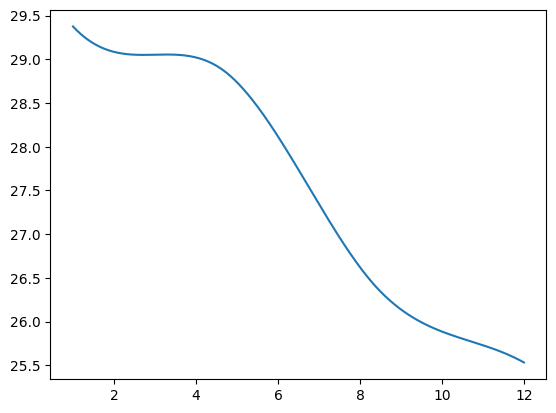

Ce que l'on recréer


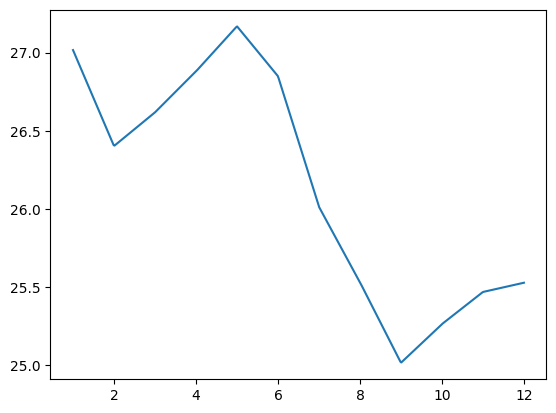

Ce que l'on est censé recréer


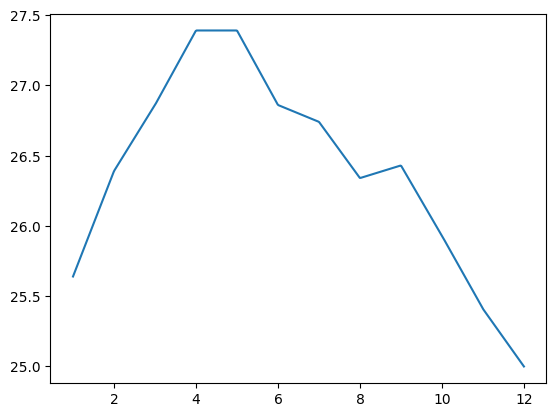

Smooth par B-Spline de ce que l'on a recréé


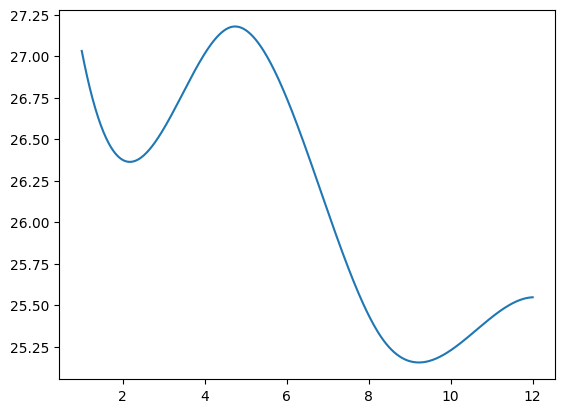

Ce que l'on est censé recréer mais smooth


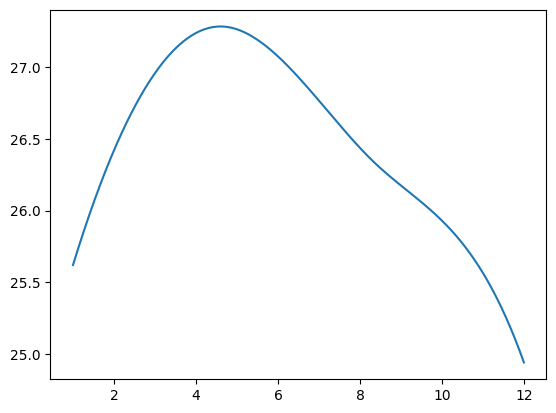

Ce que l'on recréer


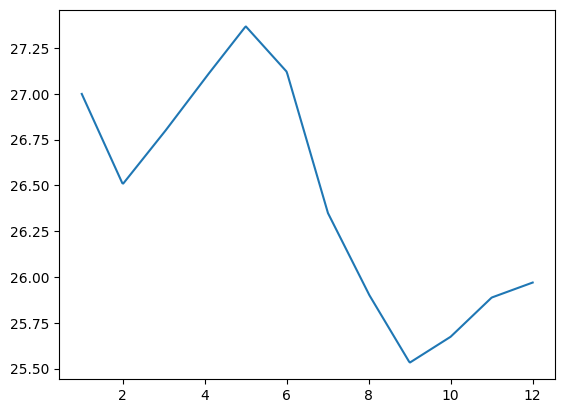

Ce que l'on est censé recréer


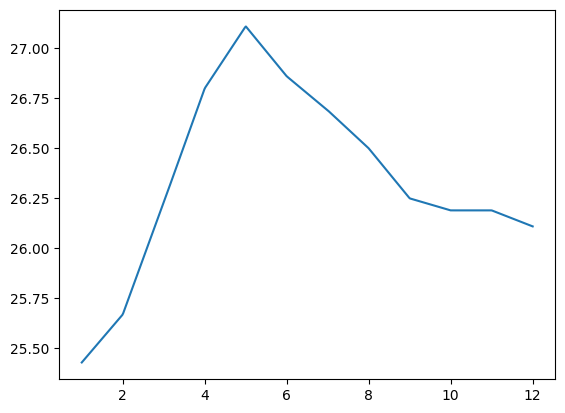

Smooth par B-Spline de ce que l'on a recréé


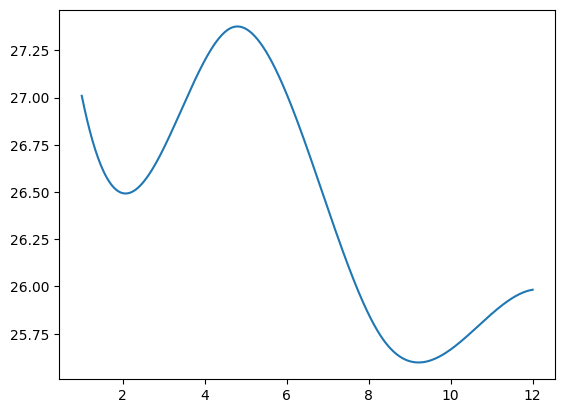

Ce que l'on est censé recréer mais smooth


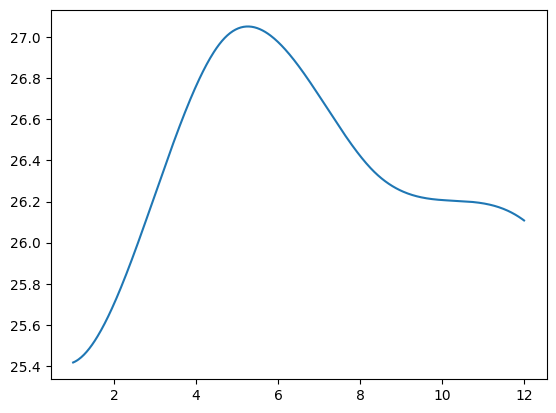

Ce que l'on recréer


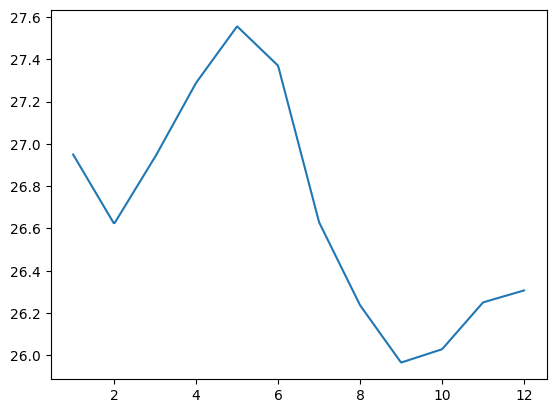

Ce que l'on est censé recréer


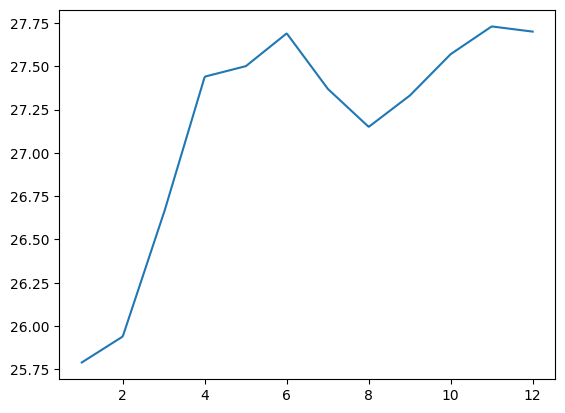

Smooth par B-Spline de ce que l'on a recréé


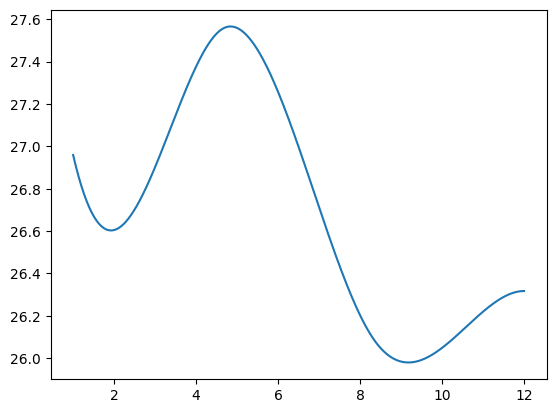

Ce que l'on est censé recréer mais smooth


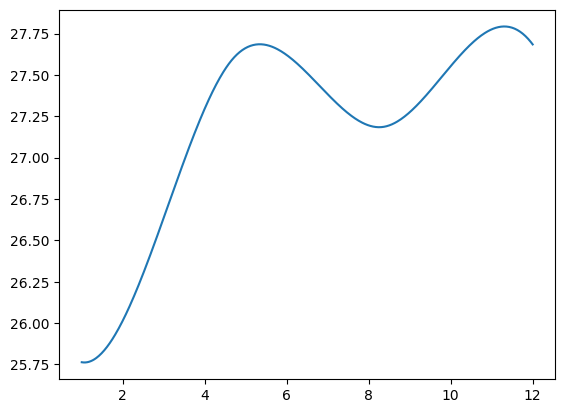

In [35]:

basis_output_CNN_FAE=skfda.representation.basis.BSplineBasis(knots=linspace(1,n_output_CNN_FAE,4))
for i in range(5):
    FDOutput=skfda.FDataGrid(CNN(region_de_test[i,:].unsqueeze(0))[:,:].detach().cpu(),grid_points=linspace(1,n_output_CNN_FAE,n_output_CNN_FAE))
    FDOutput.plot()
    print("Ce que l'on recréer")
    plt.show() 
    FD_region_test=skfda.FDataGrid(region_de_test[i,:].detach().cpu(),grid_points=ElNino_OISST_region_1and2_x)
    FD_region_test.plot()
    print("Ce que l'on est censé recréer")

    plt.show()
    Output_basis=FDOutput.to_basis(basis=basis_output_CNN_FAE)
    Output_basis.plot()
    print("Smooth par B-Spline de ce que l'on a recréé")
    plt.show()
    basis_region_de_test=FD_region_test.to_basis(basis_output_CNN_FAE)
    basis_region_de_test.plot()
    print("Ce que l'on est censé recréer mais smooth")
    plt.show()

In [102]:
loss_function(CNN(x2[1,:].unsqueeze(0)),x1)

tensor(9.9614, device='cuda:0', grad_fn=<MseLossBackward0>)

torch.Size([37, 6])


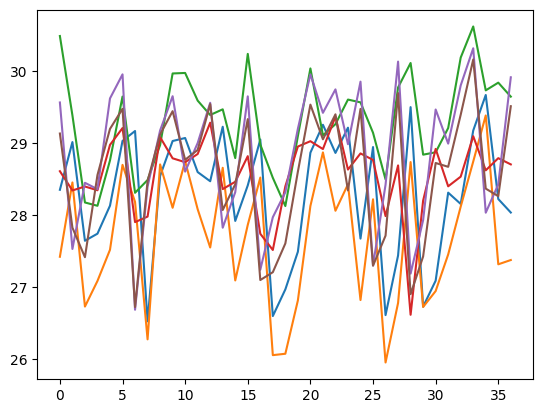

In [114]:
basis_fc=basis_region_de_test.coefficients
basis_fc=torch.tensor(basis_fc).cuda()

plt.plot(basis_fc.cpu()[:,:])
print(basis_fc.shape)
plt.show()



In [113]:

input=torch.matmul(torch.t(basis_fc),torch.mul(x0[0,:].unsqueeze(0),W.float().cuda()))

#FAE.fc1(torch.t(input).unsqueeze(0))

input=torch.t(input.float())
plt.plot(FAE.fc1(input)[:,:].detach().cpu())
plt.show()

RuntimeError: The size of tensor a (12) must match the size of tensor b (37) at non-singleton dimension 1

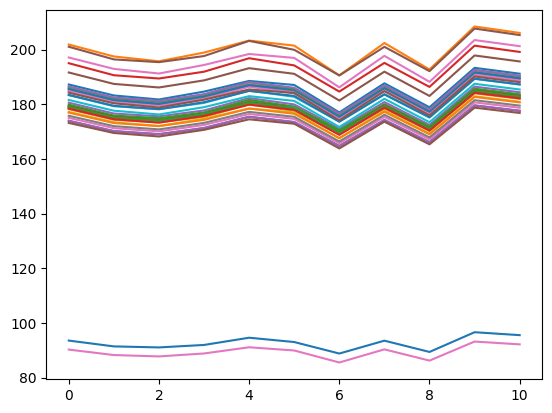

In [21]:
plt.plot(FAE.Project( x =x,basis_fc=basis_fc).cpu())
plt.show()

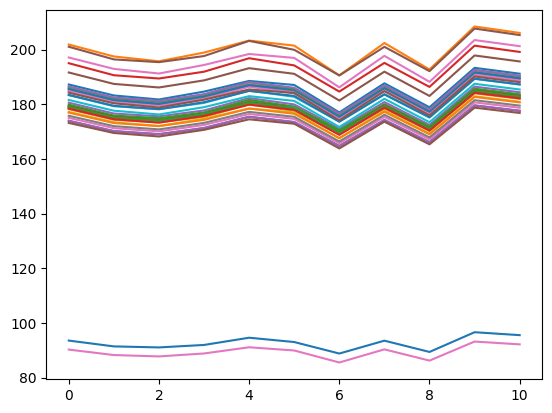

In [22]:
plt.plot(torch.matmul(torch.t(basis_fc),torch.mul(x, W.cuda())).cpu())
plt.show()


In [23]:

FAE_output_DataGrid=skfda.FDataGrid(FAE(x,basis_fc)[1].detach().cpu())

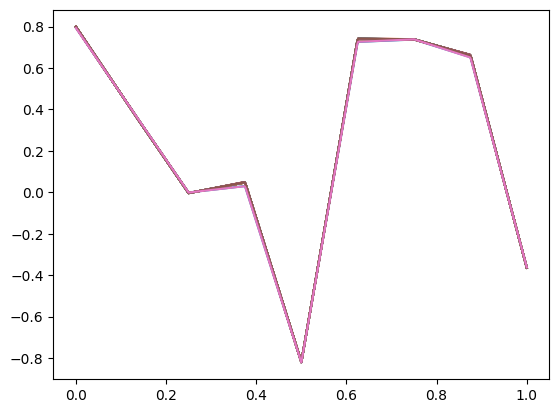

BSplineBasis(domain_range=((0.05, 0.95),), n_basis=11, order=4, knots=(0.05, 0.16249999999999998, 0.27499999999999997, 0.38749999999999996, 0.49999999999999994, 0.6125, 0.725, 0.8374999999999999, 0.95))

In [24]:
FAE_output_DataGrid.plot()
plt.show()
basis_revert=basis_region_1and_2
basis

In [ ]:
basis=skfda.representation.basis.BSplineBasis(1,12,)

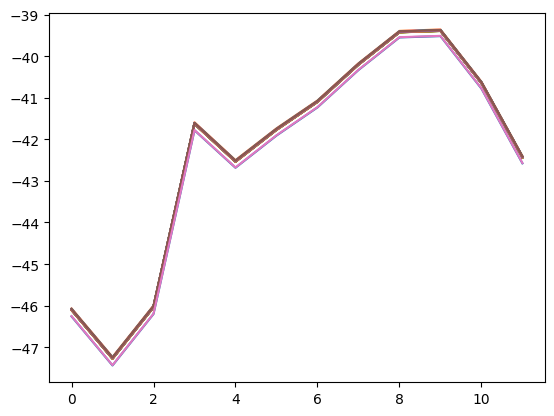

torch.Size([12, 37])

In [25]:
output,rep,feature,coef=FAE(x =x,basis_fc=basis_fc)
coef.shape
plt.plot(output.detach().cpu())
plt.show()
output.shape


coef 


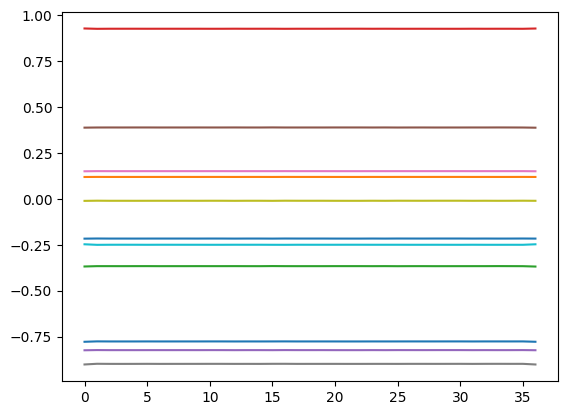

coef grid


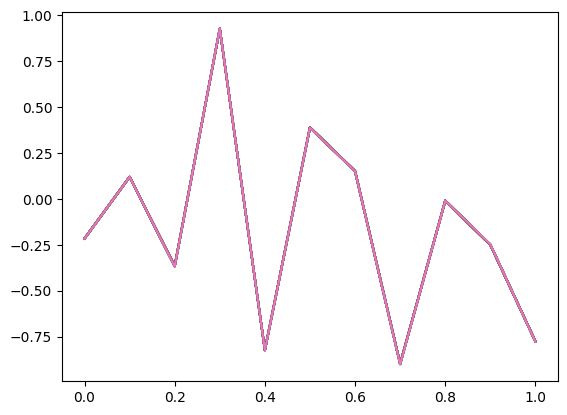

coef transposés


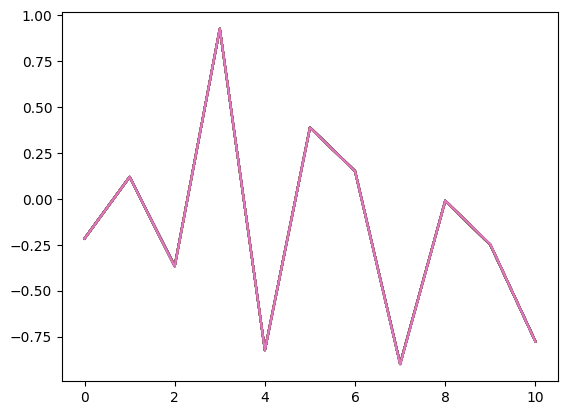

In [28]:
print("coef ")
plt.plot(coef.detach().cpu())
plt.show()
coef_grid=skfda.representation.FDataGrid(coef.detach().cpu())
print("coef grid")
coef_grid.plot()
plt.show()
print("coef transposés")
plt.plot(torch.t(coef).detach().cpu())
plt.show()

In [35]:
lr=0.0001
betas=[0.5,0.999]
batch_size=1

loss_function=nn.MSELoss()
optimizer=optim.Adam(FAE.parameters(),lr=lr,betas=betas)
indice=np.arange(37)
train_loader=torch.utils.data.DataLoader(x)
#print("Loader entier=",train_loader.dataset.shape)
#for i,b in enumerate(train_loader):
#    print ("Itération du",i,"ème batch=",b.shape)

In [37]:

from tqdm import tqdm
def train(n_epochs):
    train_loss=torch.tensor(0).cuda()
    functions_train=x    
    functions_train=functions_train.float().cuda()
    optimizer.zero_grad()
    output,rep,feature,coef=FAE(functions_train,basis_fc.float().cuda())
    loss=loss_function(feature.float(),coef.float().cuda())
    
    loss.backward()
    optimizer.step()
    train_loss+=loss.long()
    return train_loss,loss 

        


        


In [40]:
train(25000)





(tensor(30892, device='cuda:0'),
 tensor(30892.1641, device='cuda:0', grad_fn=<MseLossBackward0>))

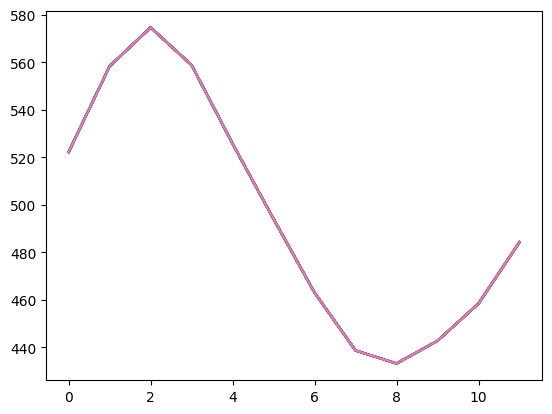

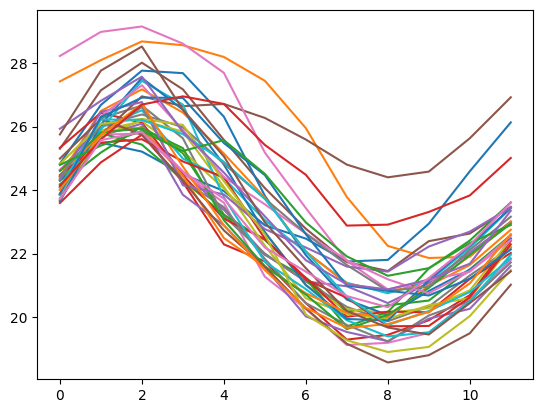

torch.Tensor

In [41]:
output,rep,feature,coef=FAE(x =x,basis_fc=basis_fc)
coef.shape
plt.plot(output[:,:].detach().cpu())
plt.show()
plt.plot(x.detach().cpu())
plt.show()
type(x)

In [ ]:
##Evaluation


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [40]:

#####################################
# Define the training procedure
#####################################
# training function
def train_FAE(train_loader, pen=None, lamb=0):  # do I need to include "loss_function", how about "optimizer"
    # It depends if you define train locally or not
    
    train_loss = 0
    score_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()  # The gradients are set to zero
        data = data.float().cuda()
        # input = data.type(torch.LongTensor)
        out,rep,feature,coef = FAE(data, basis_fc) # inputs should matches the inputs in forward function?
        ## Loss on the score layers (network output layer)
        score_loss += loss_function(feature, coef) # meaningful when basis functions are orthonormal
        ## Loss for back-propagation
        # Penalty term
        penalty = 0
        # if pen == "encoder":
        #     delta_c = model.fc1.weight[:,2:] - 2*model.fc1.weight[:,1:-1] + model.fc1.weight[:,:-2]
        #     penalty = torch.sum(delta_c**2) # torch.sum(torch.sum(delta_c**2, dim=1))
        # if pen == "decoder" :
        #     delta_c = model.fc3.weight[:,2:] - 2*model.fc3.weight[:,1:-1] + model.fc3.weight[:,:-2]
        #     penalty = torch.sum(delta_c**2) # torch.sum(torch.sum(delta_c**2, dim=1))
        if pen == "diff":
            delta_c = coef[:,2:] - 2*coef[:,1:-1] + coef[:,:-2]
            penalty = torch.mean(torch.sum(delta_c**2, dim=1))
        # for j in range(0, n_rep):
        #     penalty_rep = 0
        #     # delta_c = model.fc1.weight[j][2:] - 2*model.fc1.weight[j][1:-1] + model.fc1.weight[j][:-2]
        #     # penalty_rep = torch.sum(delta_c**2)
        #     for k in range(2, n_basis):
        #         delta_c = model.fc1.weight[j][k]-2*model.fc1.weight[j][k-1]+model.fc1.weight[j][k-2]
        #         penalty_rep += delta_c**2
        #     penalty += penalty_rep
        loss = loss_function(out, input.float()) + lamb*penalty # Maybe add score_loss as well?
        # loss = loss_function(s, s_hat)
        loss.backward()  # The gradient is computed and stored.
        optimizer.step()  # .step() performs parameter update
        train_loss += loss
    return train_loss, score_loss # we need train_loss, instead of loss, for plotting


In [41]:

train_FAE(train_loader=train_loader)
## Il faut d'autres données pour cette fonction 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11x12 and 1x37)

In [407]:

# Simulated Data
nc=500
classes = 10
tpts = np.linspace(0,1,21)
x_raw,curves = DataGenerator(nc, tpts, classes,0.5)
label = np.repeat(0,nc*classes)
for j in range(1,classes):
    label[(j*nc):(j+1)*nc] = np.repeat(j,nc)

# Prepare numpy/tensor data
x_np = np.array(x_raw).astype(float)
x = torch.tensor(x_np).float()
x = x - torch.mean(x,0)

# Rescale timestamp to [0,1]

#tpts = torch.tensor(np.array(tpts_np))

#tpts = torch.tensor(np.array(tpts_np))
n_tpts = len(tpts)
# tpts = np.linspace(0,1,num=10)

#####################################
# Perform FAE (Model Training)
#####################################
# niter = 20
# seed(1432)
# niter_seed = random.sample(range(5000), niter)
niter = 10
seed(743)
niter_seed = random.sample(range(1000), niter)



In [327]:

# Set up parameters
n_basis = 30
n_rep = 5
lamb = 0
pen = "diff"
basis_type = "Bspline"
# Get basis functions evaluated
if basis_type == "Bspline":
    bss = skfda.representation.basis.BSpline(n_basis=n_basis, order=4)
elif basis_type == "Fourier":
    bss = skfda.representation.basis.Fourier([min(tpts.numpy().flatten()), max(tpts.numpy().flatten())], n_basis=n_basis)

bss_eval = bss.evaluate(tpts, derivative=0)
basis_fc = torch.from_numpy(bss_eval[:, :, 0]).float()

# Set up empty lists
FAE_train_no_niter = []
FAE_reps_train_niter = []
FAE_reps_test_niter = []
FAE_reps_all_niter = []
FAE_pred_test_niter = []
FAE_pred_all_niter = []
FAE_pred_train_acc_mean_niter = []
FAE_pred_test_acc_mean_niter = []
FAE_pred_train_acc_sd_niter = []
FAE_pred_test_acc_sd_niter = []
classification_FAE_train_niter = []
classification_FAE_test_niter = []
clustering_FAE_acc_niter = []
clustering_FAE_acc_mean_niter = []
clustering_FAE_acc_sd_niter = []


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_15940\1844481363.py:13: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  bss_eval = bss.evaluate(tpts, derivative=0)


In [420]:

# Set up NN hyperparameters:
epochs = 25
batch_size = 32


# Start iterations
for i in range(niter):
    # Split training/test set
    TrainData, TestData, TrainLabel, TestLabel, train_no =train_test_split(x, label, split_rate =0.8, seed_no=niter_seed[i])
    FAE_train_no_niter.append(train_no)
    # Define data loaders; DataLoader is used to load the dataset for training
    train_loader = torch.utils.data.DataLoader(TrainData, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(TestData)

    # Model Initialization
    model = FAE_vanilla(weight_std=1)
    model=model.cuda()
    # Validation using MSE Loss function
    loss_function = nn.MSELoss()
    # Using an Adam Optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    # Set to CPU/GPU
    device = torch.device("cuda:0")  # (?)should be CUDA when running on the big powerfull server

    epochs = epochs
    # losses = []
    # score_losses = []

    # Train model
    for epoch in range(1, epochs + 1):
        loss, score_loss = train(train_loader=train_loader, pen=pen, lamb=lamb)
        # losses.append(loss.detach().numpy())
        # score_losses.append(score_loss.detach().numpy())
        #if epoch == epochs:
        FAE_pred_test, FAE_reps_test, FAE_pred_loss_test, FAE_pred_score_loss_test = pred(model, TestData)
        if epoch % 100 == 0:
            print(f"Epoch[{epoch}]-loss: {loss:.4f}; feature loss: {score_loss: 4f}; pred_loss:{FAE_pred_loss_test:4f}")

    # Debug by looking at loss
    # plt.plot(losses, label = "train_loss")
    # plt.legend()
   

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
 # plt.show()
    # plt.close()

    # Debug by looking at the FAE, layer by layer
    # s = model.Project(input,basis_fc)
    # rep = model.activation(model.fc1(s))
    # s_hat = model.activation(model.fc3(rep))
    # output = model.Revert(s_hat,basis_fc)

    FAE_reps_test_niter.append(FAE_reps_test)
    FAE_pred_test_niter.append(FAE_pred_test)
    FAE_pred_all, FAE_reps_all = pred(model, x)[0:2]
    FAE_reps_all_niter.append(FAE_reps_all)
    FAE_pred_all_niter.append(FAE_pred_all)

    # FAE_pred_test_acc_mean_niter.append(eval_mse_sdse(TestData, FAE_pred_test)[0].tolist())
    FAE_pred_test_acc_mean_niter.append(FAE_pred_loss_test.tolist())
    FAE_pred_test_acc_sd_niter.append(eval_mse_sdse(TestData, FAE_pred_test)[1].tolist())

    FAE_pred_train, FAE_reps_train, FAE_pred_loss_train, FAE_pred_score_loss_train = pred(model, TrainData)
    FAE_reps_train_niter.append(FAE_reps_train)
    FAE_pred_train_acc_mean_niter.append(FAE_pred_loss_train.tolist())
    FAE_pred_train_acc_sd_niter.append(eval_mse_sdse(TrainData, FAE_pred_train)[1].tolist())

    ## Classification
    # Create classifiers (logistic regression) & train the model with the training set
    FAE_classifier = LogisticRegression(solver='liblinear', random_state=0, multi_class='auto').fit(FAE_reps_train.detach().numpy(), TrainLabel)
    # Evaluate the classifier with the test set
    # FAE_classifier.predict(FAE_reps_test)
    # Classification accuracy on the test set
    classification_FAE_test_niter.append(FAE_classifier.score(FAE_reps_test.detach().numpy(), TestLabel))
    # Classification accuracy on the training set
    classification_FAE_train_niter.append(FAE_classifier.score(FAE_reps_train.detach().numpy(), TrainLabel))

    ## Clustering
    optimal_n_cluster = len(np.unique(label)) #len(set(label))
    kmeans_par = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 0}
    kmeans_labels_FAE = KMeans(n_clusters=optimal_n_cluster, **kmeans_par).fit_predict(FAE_reps_all.detach().numpy())
    # for i in range(optimal_n_cluster):
    #     no_FAE = np.count_nonzero(kmeans_labels_FAE == i)
    acc_list_FAE = []
    label_list_FAE = []
    for j in range(optimal_n_cluster):
        ind = indices(label, lambda x: x==np.unique(label)[j])
        acc_list_FAE.append(acc(kmeans_labels_FAE[ind], optimal_n_cluster))
        label_list_FAE.append(most_frequent(kmeans_labels_FAE[ind], optimal_n_cluster))
    clustering_FAE_acc_niter.append(acc_list_FAE)
    clustering_FAE_acc_mean_niter.append(mean(acc_list_FAE))
    clustering_FAE_acc_sd_niter.append(std(acc_list_FAE))

# Print for result tables
print("--- FAE-Nonlinear Results --- \n"
      f"Train Pred Acc Mean: {mean(FAE_pred_train_acc_mean_niter):.4f}; "
      f"Train Pred Acc SD: {std(FAE_pred_train_acc_mean_niter):.4f}; \n"
      f"Test Pred Acc Mean: {mean(FAE_pred_test_acc_mean_niter):.4f}; "
      f"Test Pred Acc SD: {std(FAE_pred_test_acc_mean_niter):.4f}; \n"
      f"Train Classification Acc Mean: {mean(classification_FAE_train_niter):.4f}; "
      f"Train Classification Acc SD: {std(classification_FAE_train_niter):.4f}; \n"
      f"Test Classification Acc Mean: {mean(classification_FAE_test_niter):.4f}; "
      f"Test Classification Acc SD: {std(classification_FAE_test_niter):.4f}; \n"
      f"Clustering Acc Mean (by clusters): {np.around(mean(clustering_FAE_acc_niter, axis=0), 4)};\n" 
      #[round(i, 4) for i in mean(clustering_FAE_acc_niter, axis=0)] or [f"{num:.4f}" for num in mean(clustering_FAE_acc_niter, axis=0)]
      f"Overall Clustering Acc Mean: {mean(clustering_FAE_acc_mean_niter):.4f};")

stats.ttest_rel(classification_FAE_test_niter, classification_FPCA_test_niter)
stats.ttest_rel(classification_FAE_test_niter, classification_AE_test_niter)

# If activation function is nn.Identity()
FAE_identity_train_no_niter = FAE_train_no_niter.copy()
FAE_identity_reps_train_niter = FAE_reps_train_niter.copy()
FAE_identity_reps_test_niter = FAE_reps_test_niter.copy()
FAE_identity_reps_all_niter = FAE_reps_all_niter.copy()
FAE_identity_pred_test_niter = FAE_pred_test_niter.copy()
FAE_identity_pred_all_niter = FAE_pred_all_niter.copy()
FAE_identity_pred_train_acc_mean_niter = FAE_pred_train_acc_mean_niter.copy()
FAE_identity_pred_test_acc_mean_niter = FAE_pred_test_acc_mean_niter.copy()
FAE_identity_pred_train_acc_sd_niter = FAE_pred_train_acc_sd_niter.copy()
FAE_identity_pred_test_acc_sd_niter = FAE_pred_test_acc_sd_niter.copy()
classification_FAE_identity_train_niter = classification_FAE_train_niter.copy()
classification_FAE_identity_test_niter = classification_FAE_test_niter.copy()
clustering_FAE_identity_acc_niter = clustering_FAE_acc_niter.copy()
clustering_FAE_identity_acc_mean_niter = clustering_FAE_acc_mean_niter.copy()
clustering_FAE_identity_acc_sd_niter = clustering_FAE_acc_sd_niter.copy()


In [ ]:

# Print for result tables
print("--- FAE-Nonlinear Results --- \n"
      f"Train Pred Acc Mean: {mean(FAE_pred_train_acc_mean_niter):.4f}; "
      f"Train Pred Acc SD: {std(FAE_pred_train_acc_mean_niter):.4f}; \n"
      f"Test Pred Acc Mean: {mean(FAE_pred_test_acc_mean_niter):.4f}; "
      f"Test Pred Acc SD: {std(FAE_pred_test_acc_mean_niter):.4f}; \n"
      f"Train Classification Acc Mean: {mean(classification_FAE_train_niter):.4f}; "
      f"Train Classification Acc SD: {std(classification_FAE_train_niter):.4f}; \n"
      f"Test Classification Acc Mean: {mean(classification_FAE_test_niter):.4f}; "
      f"Test Classification Acc SD: {std(classification_FAE_test_niter):.4f}; \n"
      f"Clustering Acc Mean (by clusters): {np.around(mean(clustering_FAE_acc_niter, axis=0), 4)};\n" 
      #[round(i, 4) for i in mean(clustering_FAE_acc_niter, axis=0)] or [f"{num:.4f}" for num in mean(clustering_FAE_acc_niter, axis=0)]
      f"Overall Clustering Acc Mean: {mean(clustering_FAE_acc_mean_niter):.4f};")

stats.ttest_rel(classification_FAE_test_niter, classification_FPCA_test_niter)
stats.ttest_rel(classification_FAE_test_niter, classification_AE_test_niter)

# If activation function is nn.Identity()
FAE_identity_train_no_niter = FAE_train_no_niter.copy()
FAE_identity_reps_train_niter = FAE_reps_train_niter.copy()
FAE_identity_reps_test_niter = FAE_reps_test_niter.copy()
FAE_identity_reps_all_niter = FAE_reps_all_niter.copy()
FAE_identity_pred_test_niter = FAE_pred_test_niter.copy()
FAE_identity_pred_all_niter = FAE_pred_all_niter.copy()
FAE_identity_pred_train_acc_mean_niter = FAE_pred_train_acc_mean_niter.copy()
FAE_identity_pred_test_acc_mean_niter = FAE_pred_test_acc_mean_niter.copy()
FAE_identity_pred_train_acc_sd_niter = FAE_pred_train_acc_sd_niter.copy()
FAE_identity_pred_test_acc_sd_niter = FAE_pred_test_acc_sd_niter.copy()
classification_FAE_identity_train_niter = classification_FAE_train_niter.copy()
classification_FAE_identity_test_niter = classification_FAE_test_niter.copy()
clustering_FAE_identity_acc_niter = clustering_FAE_acc_niter.copy()
clustering_FAE_identity_acc_mean_niter = clustering_FAE_acc_mean_niter.copy()
clustering_FAE_identity_acc_sd_niter = clustering_FAE_acc_sd_niter.copy()


In [ ]:

    FAE_reps_test_niter.append(FAE_reps_test)
    FAE_pred_test_niter.append(FAE_pred_test)
    FAE_pred_all, FAE_reps_all = pred(model, x)[0:2]
    FAE_reps_all_niter.append(FAE_reps_all)
    FAE_pred_all_niter.append(FAE_pred_all)

    # FAE_pred_test_acc_mean_niter.append(eval_mse_sdse(TestData, FAE_pred_test)[0].tolist())
    FAE_pred_test_acc_mean_niter.append(FAE_pred_loss_test.tolist())
    FAE_pred_test_acc_sd_niter.append(eval_mse_sdse(TestData, FAE_pred_test)[1].tolist())

    FAE_pred_train, FAE_reps_train, FAE_pred_loss_train, FAE_pred_score_loss_train = pred(model, TrainData)
    FAE_reps_train_niter.append(FAE_reps_train)
    FAE_pred_train_acc_mean_niter.append(FAE_pred_loss_train.tolist())
    FAE_pred_train_acc_sd_niter.append(eval_mse_sdse(TrainData, FAE_pred_train)[1].tolist())

    ## Classification
    # Create classifiers (logistic regression) & train the model with the training set
    FAE_classifier = LogisticRegression(solver='liblinear', random_state=0, multi_class='auto').fit(FAE_reps_train.detach().numpy(), TrainLabel)
    # Evaluate the classifier with the test set
    # FAE_classifier.predict(FAE_reps_test)
    # Classification accuracy on the test set
    classification_FAE_test_niter.append(FAE_classifier.score(FAE_reps_test.detach().numpy(), TestLabel))
    # Classification accuracy on the training set
    classification_FAE_train_niter.append(FAE_classifier.score(FAE_reps_train.detach().numpy(), TrainLabel))

    ## Clustering
    optimal_n_cluster = len(np.unique(label)) #len(set(label))
    kmeans_par = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 0}
    kmeans_labels_FAE = KMeans(n_clusters=optimal_n_cluster, **kmeans_par).fit_predict(FAE_reps_all.detach().numpy())
    # for i in range(optimal_n_cluster):
    #     no_FAE = np.count_nonzero(kmeans_labels_FAE == i)
    acc_list_FAE = []
    label_list_FAE = []
    for j in range(optimal_n_cluster):
        ind = indices(label, lambda x: x==np.unique(label)[j])
        acc_list_FAE.append(acc(kmeans_labels_FAE[ind], optimal_n_cluster))
        label_list_FAE.append(most_frequent(kmeans_labels_FAE[ind], optimal_n_cluster))
    clustering_FAE_acc_niter.append(acc_list_FAE)
    clustering_FAE_acc_mean_niter.append(mean(acc_list_FAE))
    clustering_FAE_acc_sd_niter.append(std(acc_list_FAE))

# Print for result tables
print("--- FAE-Nonlinear Results --- \n"
      f"Train Pred Acc Mean: {mean(FAE_pred_train_acc_mean_niter):.4f}; "
      f"Train Pred Acc SD: {std(FAE_pred_train_acc_mean_niter):.4f}; \n"
      f"Test Pred Acc Mean: {mean(FAE_pred_test_acc_mean_niter):.4f}; "
      f"Test Pred Acc SD: {std(FAE_pred_test_acc_mean_niter):.4f}; \n"
      f"Train Classification Acc Mean: {mean(classification_FAE_train_niter):.4f}; "
      f"Train Classification Acc SD: {std(classification_FAE_train_niter):.4f}; \n"
      f"Test Classification Acc Mean: {mean(classification_FAE_test_niter):.4f}; "
      f"Test Classification Acc SD: {std(classification_FAE_test_niter):.4f}; \n"
      f"Clustering Acc Mean (by clusters): {np.around(mean(clustering_FAE_acc_niter, axis=0), 4)};\n" 
      #[round(i, 4) for i in mean(clustering_FAE_acc_niter, axis=0)] or [f"{num:.4f}" for num in mean(clustering_FAE_acc_niter, axis=0)]
      f"Overall Clustering Acc Mean: {mean(clustering_FAE_acc_mean_niter):.4f};")

stats.ttest_rel(classification_FAE_test_niter, classification_FPCA_test_niter)
stats.ttest_rel(classification_FAE_test_niter, classification_AE_test_niter)

# If activation function is nn.Identity()
FAE_identity_train_no_niter = FAE_train_no_niter.copy()
FAE_identity_reps_train_niter = FAE_reps_train_niter.copy()
FAE_identity_reps_test_niter = FAE_reps_test_niter.copy()
FAE_identity_reps_all_niter = FAE_reps_all_niter.copy()
FAE_identity_pred_test_niter = FAE_pred_test_niter.copy()
FAE_identity_pred_all_niter = FAE_pred_all_niter.copy()
FAE_identity_pred_train_acc_mean_niter = FAE_pred_train_acc_mean_niter.copy()
FAE_identity_pred_test_acc_mean_niter = FAE_pred_test_acc_mean_niter.copy()
FAE_identity_pred_train_acc_sd_niter = FAE_pred_train_acc_sd_niter.copy()
FAE_identity_pred_test_acc_sd_niter = FAE_pred_test_acc_sd_niter.copy()
classification_FAE_identity_train_niter = classification_FAE_train_niter.copy()
classification_FAE_identity_test_niter = classification_FAE_test_niter.copy()
clustering_FAE_identity_acc_niter = clustering_FAE_acc_niter.copy()
clustering_FAE_identity_acc_mean_niter = clustering_FAE_acc_mean_niter.copy()
clustering_FAE_identity_acc_sd_niter = clustering_FAE_acc_sd_niter.copy()


In [ ]:

# Print for result tables
print("--- FAE-Indentity Results --- \n"
      f"Train Pred Acc Mean: {mean(FAE_identity_pred_train_acc_mean_niter):.4f}; "
      f"Train Pred Acc SD: {std(FAE_identity_pred_train_acc_mean_niter):.4f}; \n"
      f"Test Pred Acc Mean: {mean(FAE_identity_pred_test_acc_mean_niter):.4f}; "
      f"Test Pred Acc SD: {std(FAE_identity_pred_test_acc_mean_niter):.4f}; \n"
      f"Train Classification Acc Mean: {mean(classification_FAE_identity_train_niter):.4f}; "
      f"Train Classification Acc SD: {std(classification_FAE_identity_train_niter):.4f}; \n"
      f"Test Classification Acc Mean: {mean(classification_FAE_identity_test_niter):.4f}; "
      f"Test Classification Acc SD: {std(classification_FAE_identity_test_niter):.4f}; \n"
      f"Clustering Acc Mean (by clusters): {np.around(mean(clustering_FAE_identity_acc_niter, axis=0), 4)};\n" 
      f"Overall Clustering Acc Mean: {mean(clustering_FAE_identity_acc_mean_niter):.4f};")



In [ ]:

# Plot of Input (Observed Curves) & Output Curves (Predicted Curves)
i=1
TestData = x[[j for j in range(len(x)) if j not in FAE_train_no_niter[i]]]
input_plt = TestData.detach().numpy()
FAE_pred_plt = FAE_pred_test_niter[i].detach().numpy()

plt.figure(2, figsize=(10, 20))
plt.subplot(211)
for m in range(0, len(input_plt)):
# for m in id_plt:
    plt.plot(tpts, input_plt[m])
plt.title("Raw Curves")
plt.subplot(212)
for m in range(0, len(FAE_pred_plt)):
# for m in id_plt:
    plt.plot(tpts, FAE_pred_plt[m])
plt.title("FAE-predicted Curves")
plt.show()

# Perform paired t-test
stats.ttest_rel(FAE_identity_pred_test_acc_mean_niter, FPCA_pred_test_acc_mean_niter)
stats.ttest_rel(classification_FAE_identity_test_niter, classification_FPCA_test_niter)
stats.ttest_rel(clustering_FAE_identity_acc_mean_niter, clustering_FPCA_acc_mean_niter)é